In [1]:
using RigidBodyTreeInspector
using RigidBodyDynamics
using StaticArrays
using CoordinateTransformations
using DataFrames, DataArrays
using Gadfly
using ProfileView
import SimpleGradientDescent: NaiveSolver

adding: /Users/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.5/DrakeVisualizer/src/lcmtypes to the python path


In [29]:
import Flash

In [39]:
urdf = "$(ENV["HOME"])/locomotion/explorations/point-cloud-signed-distance/examples/data/IRB140/urdf/irb_140_convhull.urdf"
package_path = ["$(ENV["HOME"])/locomotion/drake-distro/drake/examples"]
mechanism = parse_urdf(Float64, urdf);
vis = parse_urdf(urdf, mechanism; package_path=package_path);
inspect(mechanism, vis)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint1.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint2.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint3.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint4.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint5.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"joint6.1",0.0,linspace(-3.141592653589793,3.141592653589793,51),".3f",true)

nothing

In [40]:
model = Flash.Models.load_urdf(urdf, package_path=package_path)

Manipulator with 8 links and 7 surfaces

In [41]:
# Construct the sensor and draw its view rays for debugging
sensor = Flash.DepthSensors.Kinect(41, 41);
camera_origin = SVector(0., 1.5, 0.5)
camera_tform = compose(Translation(camera_origin), LinearMap(AngleAxis(pi/2, 1, 0, 0)))
Flash.DepthSensors.draw_rays(sensor, camera_tform)

In [42]:
state = Flash.ManipulatorState(model);
skin = Flash.skin(state);
Visualizer(DrakeVisualizer.contour_mesh(skin, [-.5, -.5, -.25], [1., .5, 1], 0.01, 0.05))

LoadError: LoadError: Base.LinAlg.SingularException(8)
while loading In[42], in expression starting on line 2

In [17]:
# Difference between two angles, compensating for wraparound
# (taken from angleDiff.m in Drake)
function angle_diff(phi1, phi2)
    mod(phi2 - phi1 + pi, 2*pi) - pi;
end

angle_diff (generic function with 1 method)

In [18]:
vis_data = RigidBodyTreeInspector.parse_urdf_visuals(urdf, model.mechanism; package_path=package_path);
vis_true, vis_estimated = Visualizer([convert(DrakeVisualizer.Robot, vis_data) for i in 1:2]);

In [19]:
# Now let's try to use the raycast data to recover the joint angles.
# We'll do that by choosing a true (hidden) robot state:
true_state = Flash.ManipulatorState(model)
true_origins = Flash.link_origins(true_state)
DrakeVisualizer.draw(vis_true, true_origins)

# Now we can raycast that true state to get a set of sensed points:
sensed_points = Flash.DepthSensors.raycast(true_state, sensor, camera_tform)
Flash.DepthSensors.draw_points(sensed_points)

In [22]:
function test_gradient_descent(model, sensed_points, true_state, loops)
    x_true = copy(Flash.flatten(true_state))
    trials = Vector{DataFrame}()
    
    for i = 1:loops
        errors = Float64[]
        xs = Vector{Float64}[]
        costs = Float64[]
        
        function callback{T}(x::AbstractVector{T}, c)
            # When computing errors, we'll just ignore the last three joints, since
            # they are almost impossible to track at this scale
            x_value = Flash.value.(x)
            push!(errors, norm(angle_diff.(x_value[1:end-3], x_true[1:end-3])))
            push!(xs, x_value)
            push!(costs, Flash.value(c))
            origins = Flash.link_origins(model, x_value[1:num_positions(model.mechanism)])
            DrakeVisualizer.draw(vis_estimated, origins)
        end
        
        x_estimated = copy(x_true)
        x_estimated += pi * (rand(length(x_estimated)) - 0.5)
        Flash.Tracking.estimate_state(model, 
            sensed_points, x_estimated; callback=callback,
        solver=NaiveSolver(length(x_estimated),
                              rate=20.0,
                              max_step=0.5,
                              iteration_limit=50,
                            gradient_convergence_tolerance=1e-4))
        push!(trials, DataFrame(x=xs, err=errors, cost=costs))
    end
    
    trials
end


test_gradient_descent (generic function with 1 method)

In [23]:
trials = test_gradient_descent(model, sensed_points, true_state, 10);

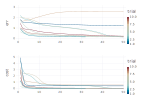

In [24]:
vstack(Gadfly.plot([layer(trial, y="err", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial")),
    Gadfly.plot([layer(trial, y="cost", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial")))